In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image
import random
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping,Callback,ModelCheckpoint
from time import time
import itertools
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


# Dataset generator

In [5]:
def create_dataset(folder,shuffle_image = True):
    image_array =[]
    class_name = []
    for dir_name in os.listdir(folder):
        for file in os.listdir(os.path.join(folder,dir_name)):
            image_path = os.path.join(folder,dir_name,file)
            image = np.array(Image.open(image_path).resize((80,128)).convert('L')).flatten().reshape(1,-1)[0]
            image = image.astype('float32')
            image /= 255
            image_array.append(image)
            class_name.append(dir_name)
    if shuffle_image == True:
        image, classes = shuffle(np.array(image_array),np.array(class_name))
    else:
        image, classes = image_array,class_name
    return image, classes    

In [6]:
train = r'/jet/home/mhrahman/Projects/HW1/Output/train/'
val =  r'/jet/home/mhrahman/Projects/HW1/Output/val/'
test = r'/jet/home/mhrahman/Projects/HW1/Output/test/'

In [7]:
train_image, train_lab = create_dataset(train)
val_image,val_lab = create_dataset(val)
test_image,test_lab = create_dataset(test,shuffle_image=False)

In [5]:
train_dict = {k:v for v,k in enumerate(np.unique(train_lab))}
train_label = [train_dict[train_lab[i]] for i in range(len(train_lab))]
val_dict = {k:v for v,k in enumerate(np.unique(val_lab))}
val_label = [val_dict[val_lab[i]] for i in range(len(val_lab))]
test_dict = {k:v for v,k in enumerate(np.unique(test_lab))}
test_label = [test_dict[test_lab[i]] for i in range(len(test_lab))] 

# Conversion to PCs

In [4]:
def PCA_convert(array, n_component):
    pca = PCA(n_components=n_component)
    converted = pca.fit_transform(array)
    return converted

In [1]:
pca = PCA(2000).fit(np.array(train_image))
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.figure(figsize=(10,6))
plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio',fontsize = 16)
plt.xlabel('Principal component index',fontsize = 16)
plt.xticks(np.arange(1, 2001, step=100))
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('/jet/home/mhrahman/Projects/HW4/Figures/PCA_variance_main.jpg',dpi = 300)
plt.show()

NameError: name 'PCA' is not defined

In [9]:
t1 = time()
PCs = 2000
train_pca = PCA_convert(np.array(train_image),PCs)

In [ ]:
val_pca = PCA_convert(np.array(val_image),PCs)
test_pca = PCA_convert(np.array(test_image),PCs)

# Model Setup

In [13]:
nn_model = Sequential()
nn_model.add(Dense(units=128,input_dim = PCs,activation = 'relu'))
nn_model.add(Dense(units=64,activation='relu'))
nn_model.add(Dense(units=2, activation='softmax'))

In [14]:
class TimeCallback(Callback):
    def on_train_begin(self,logs={}):
        self.logs=[]
    def on_epoch_begin(self,epoch,logs={}):
        self.starttime = time()
    def on_epoch_end(self,epoch,logs={}):
        self.logs.append(time()-self.starttime)
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1, patience = 20,min_delta = 1)
cb = TimeCallback()
checkpoints = ModelCheckpoint('weight_03.hdf5',monitor='accuracy',verbose=1,save_best_only= True,mode='max')

In [15]:
nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nn_model.summary()
with open('modelsummary.txt', 'w') as f:
    nn_model.summary(print_fn=lambda x: f.write(x + '\n'))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               70528     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 78,914
Trainable params: 78,914
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_history = nn_model.fit(train_pca,
                          np.array(list(map(int,train_label)),np.float32),
                          batch_size = 64,
                          validation_data=(val_pca, np.array(list(map(int,val_label)),np.float32)), 
                             epochs=10, verbose=1, callbacks = [es,cb,checkpoints])

Train on 14333 samples, validate on 4777 samples
Epoch 1/10
14208/14333 [============================>.] - ETA: 0s - loss: 0.0354 - accuracy: 0.9918
Epoch 00001: accuracy improved from -inf to 0.99184, saving model to weight_03.hdf5
14333/14333 [==============================] - 15s 1ms/sample - loss: 0.0351 - accuracy: 0.9918 - val_loss: 0.0033 - val_accuracy: 0.9998
Epoch 2/10
14272/14333 [============================>.] - ETA: 0s - loss: 1.7829e-04 - accuracy: 1.0000
Epoch 00002: accuracy improved from 0.99184 to 1.00000, saving model to weight_03.hdf5
14333/14333 [==============================] - 16s 1ms/sample - loss: 1.7822e-04 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 3/10
14272/14333 [============================>.] - ETA: 0s - loss: 6.7749e-05 - accuracy: 1.0000
Epoch 00003: accuracy did not improve from 1.00000
14333/14333 [==============================] - 17s 1ms/sample - loss: 6.7657e-05 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000

# Model evaluation

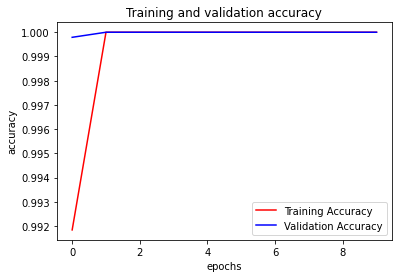

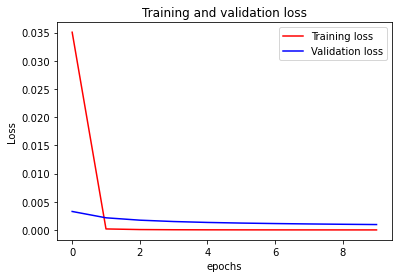

In [19]:
#plot training and validation curve
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r')
plt.plot(epochs,val_acc,'b')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(["Training Accuracy","Validation Accuracy"])
plt.savefig('/jet/home/mhrahman/Projects/HW4/Figures/Classification_acc.jpg',dpi = 300)
plt.show()


plt.plot(epochs,loss,'r')
plt.plot(epochs,val_loss,'b')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(["Training loss","Validation loss"])
plt.savefig('/jet/home/mhrahman/Projects/HW4/Figures/Classification_loss.jpg',dpi = 300)
plt.show()

In [20]:
Y_pred_label = nn_model.predict_classes(test_pca)

In [21]:
def plot_confusion_matrix(cm,classes,normalize = False,title = 'Confusion matrix',cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astyle('float')/cm.sum(axis = 1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normazlization')
    print(cm)
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation = 45)
    plt.yticks(tick_marks,classes)
    threshold = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment = 'center',
                color = "red" if cm[i,j]> threshold else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normazlization
[[1897  537]
 [ 227 2119]]


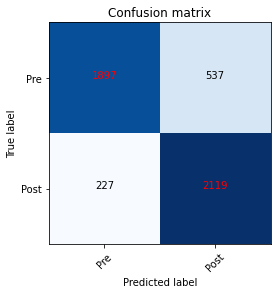

In [22]:
cm = confusion_matrix(test_label,Y_pred_label)
cm_plot_labels = ['Pre','Post']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels)
plt.savefig('/jet/home/mhrahman/Projects/HW4/Figures/Classification_conf_mat.jpg', dpi = 300)
plt.show()

In [27]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_curve,roc_auc_score
accuray = accuracy_score(test_label,Y_pred_label)
precision = precision_score(test_label,Y_pred_label)
recall = recall_score(test_label,Y_pred_label)
F1 = f1_score(test_label,Y_pred_label)
print('Accuracy: {}'.format(accuray))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1_score: {}'.format(F1))

Accuracy: 0.8401673640167364
Precision: 0.797816265060241
Recall: 0.9032395566922421
F1_score: 0.8472610955617752


In [25]:
auc_score = roc_auc_score(test_label,Y_pred_label)
fpr,tpr,_ = roc_curve(test_label,Y_pred_label)
print(auc_score)

0.8413075351250857


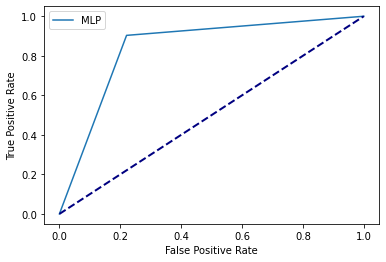

In [26]:
plt.plot(fpr,tpr,linestyle = '-',label = 'MLP')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('/jet/home/mhrahman/Projects/HW4/Figures/Roc_curve.jpg',dpi = 300)
plt.show()

In [ ]:
t2 = time()
print('Time:', t2 - t1)